# Historical Activity of ClueBot NG

**Krishna Chaitanya Velaga, Data Scientist III, Wikimedia Foundation**

**Last updated on 19 August 2023**

[TASK: T343952](https://phabricator.wikimedia.org/T343952)

# Contents

1. [Summary](#Summary)
2. [Data Gathering](#Data-Gathering)
3. [Analysis](#Analysis)

# Summary
[ClueBot (NG)](https://en.wikipedia.org/wiki/User:ClueBot_NG) is an anti-vandalism bot that tries to detect and revert vandalism quickly and automatically on English Wikipedia. The bot has been operational since 2010 and had varied levels of activity.
- The bot usually monitors content namespaces and for every revert that was made, a message is posted to the user's talk page whose edit had been reverted. 
    - While there were edits made in content namespaces that are not reverts, and reverts in non-content namespaces, their frequency is insigificant, and don't add any value to the analysis.
    - non-content reverts: 0.029% & content edits (excluding reverts): 0.009% of all time edits made by the bot
- From 2010 to early 2013, the bot made between 1500-2500 reverts on average per day.
- From 2013 to 2018, the average daily reverts were between 500-1000.
- From 2019 to mid-2020, the average daily reverts were between 150-250.
- Starting July 2020, the average daily reverts increased to ~500, a trend which continued until the end of 2021.
- There was a sharp drop in the daily reverts made since Jan 2022; it continued to drop until August 2022 when the bot made 65 reverts on average per day.
- From Sep 2022 to Jun 2023 (end of data), the average daily reverts were between 150-200.
- Over the years, the percentage of reverts made by ClueBot NG reverted back dropped fr

Note: As the bot posts a talk page message for each revert (in most cases), the actual edit count would approximately be double of average reverts mentioned above.

# Data-Gathering

## imports

In [248]:
import wmfdata as wmf
import pandas as pd

import plotly.graph_objects as go

pd.options.display.max_columns = None

## spark_session

In [3]:
spark_session = wmf.spark.get_active_session()

if type(spark_session) != type(None):
    spark_session.stop()
else:
    print('no active session')

no active session


In [5]:
spark_session = wmf.spark.create_custom_session(
    master="yarn",
    app_name='cluebot-activity',
    spark_config={
        "spark.driver.memory": "4g",
        "spark.dynamicAllocation.maxExecutors": 64,
        "spark.executor.memory": "16g",
        "spark.executor.cores": 4,
        "spark.sql.shuffle.partitions": 256,
        "spark.driver.maxResultSize": "2g"
        
    }
)

SPARK_HOME: /usr/lib/spark3
Using Hadoop client lib jars at 3.2.0, provided by Spark.
PYSPARK_PYTHON=/opt/conda-analytics/bin/python3


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/19 05:48:29 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [6]:
spark_session

In [7]:
spark_session.sparkContext.setLogLevel("ERROR")

## query

In [257]:
%%time

query = """
WITH
    base AS (
        SELECT 
            YEAR(event_timestamp) AS year,
            MONTH(event_timestamp) AS month,
            DAY(event_timestamp) AS day,
            DATE(event_timestamp) AS date,
            revision_id,
            CASE
                WHEN page_namespace_is_content AND revision_is_identity_revert THEN 'content_revert'
                WHEN page_namespace_is_content AND revision_is_identity_revert = False THEN 'content_edit'
                WHEN page_namespace_is_content = False AND revision_is_identity_revert THEN 'non_content_revert'
                WHEN page_namespace_is_content = False AND revision_is_identity_revert = False THEN 'non_content_edit'
            ELSE 'n/a'
            END AS edit_type,
            revision_is_identity_reverted AS revert_reverted
        FROM
            wmf.mediawiki_history
        WHERE
            snapshot = '2023-07' AND
            wiki_db = 'enwiki' AND
            event_user_text = 'ClueBot NG' AND
            DATE(event_timestamp) <= DATE('2023-06-30') AND
            page_namespace_is_content IS NOT NULL AND
            revision_is_identity_revert IS NOT NULL
    )
            
        
SELECT
    year,
    month,
    day,
    edit_type,
    date,
    revert_reverted,
    CAST(COUNT(DISTINCT revision_id) AS INT) AS edits
FROM 
    base
GROUP BY
    year,
    month,
    day,
    date,
    revert_reverted,
    edit_type
ORDER BY
    year,
    month,
    day,
    date,
    revert_reverted,
    edit_type
"""

result = wmf.spark.run(query)

CPU times: user 526 ms, sys: 120 ms, total: 646 ms
Wall time: 1min 38s


In [261]:
# pivot based on edit type

data = (
    result
    .pivot(
        index=['year', 'month', 'day', 'ymonth', 'revert_reverted'], 
        columns='edit_type', values='edits')
    .fillna(0)
    .astype(int)
)

data.columns = [col for col in data.columns]
data.head(3)

content_edit  content_revert  \
year month day ymonth  revert_reverted                                 
2010 10    28  2010-10 False                       0               0   
     11    2   2010-11 False                       0             562   
                       True                        0             128   

                                        non_content_edit  non_content_revert  
year month day ymonth  revert_reverted                                        
2010 10    28  2010-10 False                           1                   0  
     11    2   2010-11 False                         670                   0  
                       True                           18                   0

In [280]:
dtemp = data[['content_revert']].reset_index().pivot(['year', 'month', 'day', 'ymonth'], 'revert_reverted', 'content_revert').fillna(0)
dtemp.columns  = [str(col) for col in dtemp.columns]
dtemp['total'] = dtemp['False'] + dtemp['True']
dtemp['revert_percent'] = dtemp['True'] / dtemp['total'] * 100
dtemp

False   True   total  revert_percent
year month day ymonth                                        
2010 10    28  2010-10     0.0    0.0     0.0             NaN
     11    2   2010-11   562.0  128.0   690.0       18.550725
           3   2010-11  1474.0  295.0  1769.0       16.676088
           4   2010-11  1428.0  267.0  1695.0       15.752212
           5   2010-11  1064.0  189.0  1253.0       15.083799
...                        ...    ...     ...             ...
2023 6     26  2023-06   212.0   22.0   234.0        9.401709
           27  2023-06   161.0   14.0   175.0        8.000000
           28  2023-06   196.0   22.0   218.0       10.091743
           29  2023-06   170.0   17.0   187.0        9.090909
           30  2023-06   178.0   11.0   189.0        5.820106

[4525 rows x 4 columns]

In [284]:
dtm = dtemp.groupby(['year', 'month', 'ymonth']).agg({'revert_percent': 'mean'})

## data processing

In [260]:
# convert string to datetime datatype
result['ymonth'] = pd.to_datetime(result['date']).dt.strftime('%Y-%m')

In [292]:
# pivot based on edit type

data = (
    result
    .pivot(
        index=['year', 'month', 'day', 'ymonth', 'revert_reverted'], 
        columns='edit_type', values='edits')
    .fillna(0)
    .astype(int)
)

data.columns = [col for col in data.columns]
data.head(3)

content_edit  content_revert  \
year month day ymonth  revert_reverted                                 
2010 10    28  2010-10 False                       0               0   
     11    2   2010-11 False                       0             562   
                       True                        0             128   

                                        non_content_edit  non_content_revert  
year month day ymonth  revert_reverted                                        
2010 10    28  2010-10 False                           1                   0  
     11    2   2010-11 False                         670                   0  
                       True                           18                   0

In [294]:
# aggregate to month level

data_monthly = (
    round(
        data
        .groupby(['year', 'month', 'day', 'ymonth'])
        .sum()
        .groupby(['year', 'month', 'ymonth'])
        .agg({
            'content_revert': ['sum', 'mean'], 
            'non_content_edit': ['sum', 'mean']
        })
    )
    .astype(int)
    .reset_index()
)

data_monthly.head(3)

year month   ymonth content_revert       non_content_edit      
                                  sum  mean              sum  mean
0  2010    10  2010-10              0     0                1     1
1  2010    11  2010-11          45176  1613            44905  1604
2  2010    12  2010-12          46536  1501            46604  1503

In [227]:
# save data
data_monthly.to_csv('cluebot_monthly_activity.tsv', sep='\t')

In [313]:
# percentage of reverts reverted back

reverted_reverts_monthly = (
    data[['content_revert']]
    .reset_index()
    .pivot(['year', 'month', 'day', 'ymonth'], 'revert_reverted', 'content_revert')
    .fillna(0)
)

reverted_reverts_monthly.columns  = [str(col) for col in reverted_reverts_monthly.columns]

reverted_reverts_monthly = round(
    reverted_reverts_monthly
    .assign(
        revert_percent = reverted_reverts_monthly['True'] / (reverted_reverts_monthly['False'] + reverted_reverts_monthly['True']) * 100
    )
    .groupby(['year', 'month', 'ymonth'])
    .agg({
        'revert_percent': 'mean'
    })
    .fillna(0), 
    2
)

reverted_reverts_monthly.head(3)

revert_percent
year month ymonth                 
2010 10    2010-10            0.00
     11    2010-11           15.36
     12    2010-12           15.85

In [314]:
# save data
reverted_reverts_monthly.to_csv('reverted_reverts_monthly.tsv', sep='\t')

## Analysis

In [240]:
non_content_reverts_proportion = round(result.query("""edit_type == 'non_content_revert'""").edits.sum() / result.edits.sum() * 100, 3)
print(f"Percentage of non-content reverts: {non_content_reverts_proportion}%")

content_edits_proportion = round(result.query("""edit_type == 'content_edit'""").edits.sum() / result.edits.sum() * 100, 3)
print(f"Percentage of content edits (excluding reverts): {content_edits_proportion}%")

Percentage of non-content reverts: 0.029%
Percentage of content edits (excluding reverts): 0.009%


The bot usually monitors content namespaces and for every revert that was made, a message is posted to the user's talk page whose edit had been reverted. While there were edits made in content namespaces that are not reverts, and reverts in non-content namespaces, their frequency is insigificant, and don't add any value to the analysis.

## content namespace reverts (line chart)

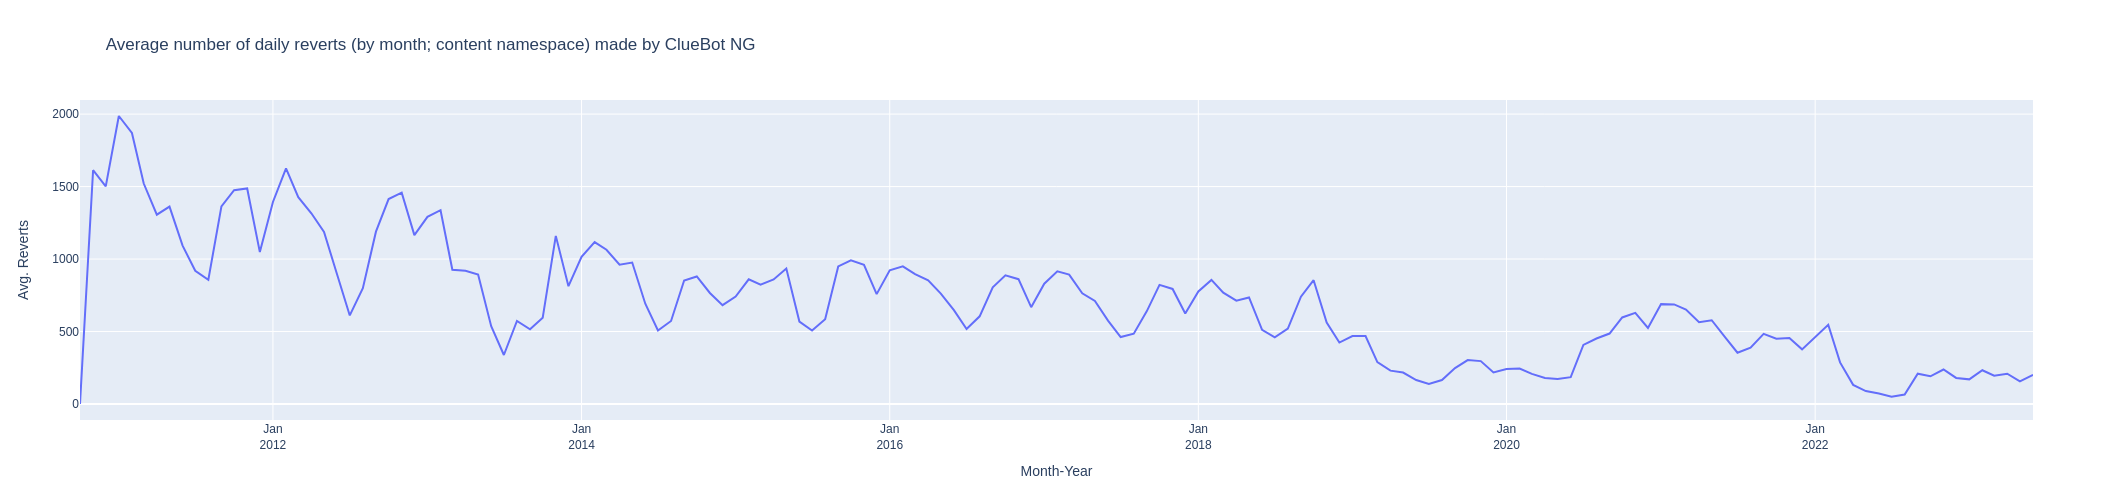

In [249]:
# line chart for reverts made in content namespaces

fig = (
    go
    .Figure([
        go.Scatter(
            x=data_monthly['ymonth'], 
            y=data_monthly.loc[:, ('content_revert', 'mean')])
    ])
    .update_layout(
        width=1250,
        height=500,
        title=dict(text='Average number of daily reverts (by month; content namespace) made by ClueBot NG'),
        xaxis_tickformat= '%b<br>%Y'
    )
    .update_xaxes(title_text='Month-Year')
    .update_yaxes(title_text='Avg. Reverts')
)

fig.show()

## non-content namespace edits (line chart)

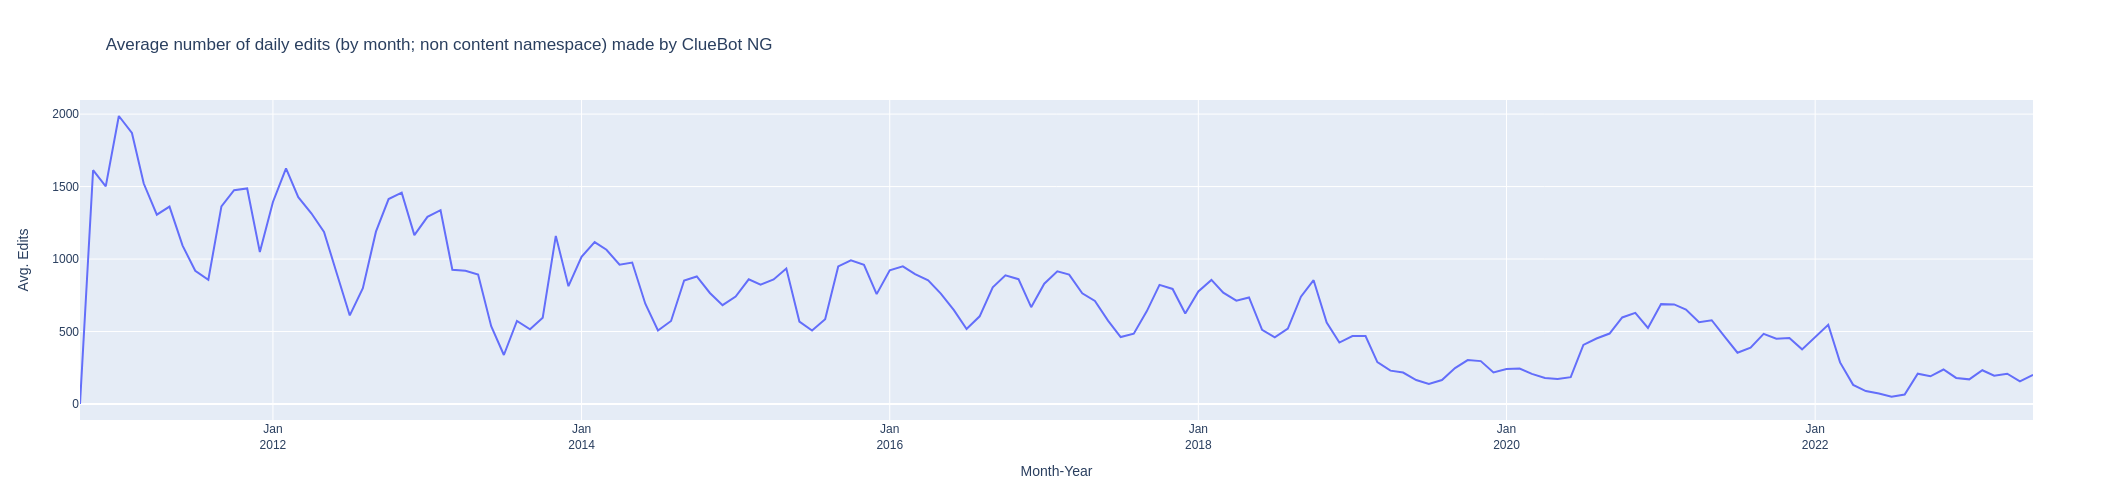

In [250]:
# line chart for edits made in non-content namespaces

fig = (
    go
    .Figure([
        go.Scatter(
            x=data_monthly['ymonth'], 
            y=data_monthly.loc[:, ('content_revert', 'mean')])
    ])
    .update_layout(
        width=1250,
        height=500,
        title=dict(text='Average number of daily edits (by month; non content namespace) made by ClueBot NG'),
        xaxis_tickformat= '%b<br>%Y'
    )
    .update_xaxes(title_text='Month-Year')
    .update_yaxes(title_text='Avg. Edits')
)

fig.show()

## percentage of reverts reverted back

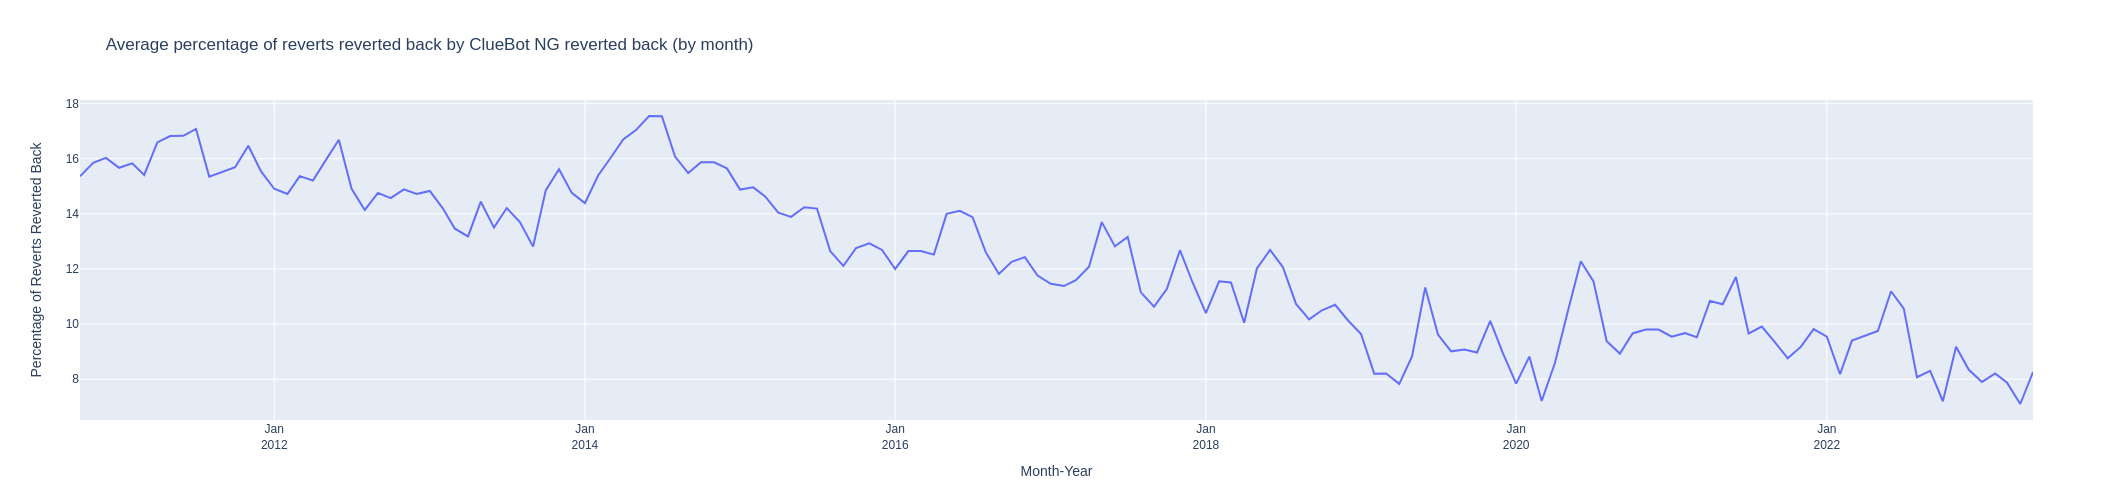

In [323]:
# line chart for edits made in non-content namespaces

fig = (
    go
    .Figure([
        go.Scatter(
            x=reverted_reverts_monthly.reset_index()['ymonth'], 
            y=reverted_reverts_monthly.query("""revert_percent > 0""")['revert_percent'])
    ])
    .update_layout(
        width=1250,
        height=500,
        title=dict(text='Average percentage of reverts reverted back by ClueBot NG reverted back (by month)'),
        xaxis_tickformat= '%b<br>%Y'
    )
    .update_xaxes(title_text='Month-Year')
    .update_yaxes(title_text='Percentage of Reverts Reverted Back')
)

fig.show()